In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
inf = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")

In [4]:
#Drop Lat, Long and Province/State columns
inf.drop(inf.columns[[0, 2, 3]], axis=1, inplace=True)
#Rename the country column name
inf.rename(columns={'Country/Region':'Country'}, inplace=True)
#Group by country to get the sums
inf_g = inf.groupby('Country').sum()
#Unpivot the data to have the dates in a single column and values in another
inf_g = inf_g.unstack().reset_index(name='value')
#Rename the columns to appropriate names
inf_g.rename(columns={'level_0':'Date','value':'TotalInfected'}, inplace=True)

In [5]:
dead=pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')

In [6]:
dead.drop(dead.columns[[0, 2, 3]], axis=1, inplace=True)
dead.rename(columns={'Country/Region':'Country'}, inplace=True)
dead_g = dead.groupby('Country').sum()
dead_g = dead_g.unstack().reset_index(name='value')
dead_g.rename(columns={'level_0':'Date','value':'TotalDeaths'}, inplace=True)

In [7]:
recov = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')

In [8]:
recov.drop(recov.columns[[0, 2, 3]], axis=1, inplace=True)
recov.rename(columns={'Country/Region':'Country'}, inplace=True)
recov_g = recov.groupby('Country').sum()
recov_g = recov_g.unstack().reset_index(name='value')
recov_g.rename(columns={'level_0':'Date','value':'TotalRecovered'}, inplace=True)

In [9]:
#Merging all the 3 data frames together
covid = pd.merge(pd.merge(inf_g, dead_g, how='inner', on=['Country','Date']), recov_g, how='inner',on=['Country','Date'])

In [10]:
#Convert the Date field to date datatype
covid['Date']= pd.to_datetime(covid['Date'])

In [11]:
#Ordering and sorting the columns in the dataframe
covid = covid[covid.columns[[1,0,2,3,4]]].sort_values(by=['Country','Date'])

In [12]:
#Adding day numbers to the dataset
covid['Day']=covid[covid['TotalInfected']>0].groupby('Country')['Date'].rank(ascending=True).astype(int)

In [13]:
#Adding daily numbers
covid['Infected'] = covid.groupby('Country')['TotalInfected'].diff(periods=1)
covid['Deaths'] = covid.groupby('Country')['TotalDeaths'].diff(periods=1)
covid['Recovered'] = covid.groupby('Country')['TotalRecovered'].diff(periods=1)

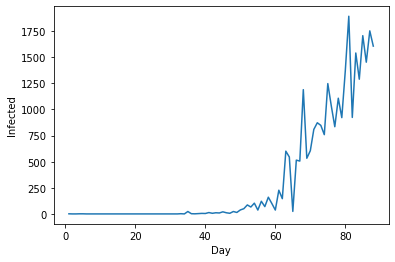

In [14]:
sns.lineplot(x='Day',y='Infected',data=covid[(covid['TotalInfected']>0) & (covid['Country']=='India')])

In [15]:
#Fixing Country Names
covid.loc[covid['Country']=='US','Country'] ='United States'
covid.loc[covid['Country']=='Brunei','Country'] ='Brunei '
covid.loc[covid['Country']=='Burma','Country'] ='Myanmar'
covid.loc[covid['Country']=='Congo (Brazzaville)','Country'] ='Congo'
covid.loc[covid['Country']=='Congo (Kinshasa)','Country'] ='DR Congo'
covid.loc[covid['Country']=='Czechia','Country'] ='Czech Republic (Czechia)'
covid.loc[covid['Country']=='Korea, South','Country'] ='South Korea'
covid.loc[covid['Country']=='Taiwan*','Country'] ='Taiwan'

In [16]:
#get world population data
from bs4 import BeautifulSoup
import requests


In [17]:
url = 'https://www.worldometers.info/world-population/population-by-country/'
html_content = requests.get(url).text

# Parse the html content
soup = BeautifulSoup(html_content, "lxml")
#print(soup.prettify()) # print the parsed data of html

In [18]:
pop_table = soup.find("table", attrs={"id": "example2"})
pop_table_data = pop_table.tbody.find_all("tr")
#pop_table_data

In [19]:
# Get all the headings of Lists
t_headers = []
for th in pop_table.find_all("th"):
    # remove any newlines and extra spaces from left and right
    t_headers.append(th.text)
#t_headers

In [20]:
data = {}
table_data = []
for tr in pop_table.tbody.find_all("tr"):
    t_row = {}
    for td, th in zip(tr.find_all("td"), t_headers): 
            t_row[th] = td.text
            table_data.append(t_row)
        # Put the data for the table with his heading.

pop_df = pd.DataFrame(table_data)

In [21]:
pop_df = pop_df.drop_duplicates()
pop_df.rename(columns={'Country (or dependency)':'Country'}, inplace=True)
#pop_df


In [22]:
covid = pd.merge(covid, pop_df[['Country','Population (2020)']], how='left', on='Country')

In [23]:
covid['InfectedRank']=covid.groupby(['Date'])['TotalInfected'].rank(method='max',ascending=False,na_option='bottom')
covid['DeathRank']=covid.groupby(['Date'])['TotalDeaths'].rank(method='max',ascending=False,na_option='bottom')
covid['RecoveredRank']=covid.groupby(['Date'])['TotalRecovered'].rank(method='max',ascending=False,na_option='bottom')
covid['Population (2020)'].fillna(0,inplace=True)

In [24]:
nonCountryList=covid.loc[covid['Population (2020)']==0,'Country'].unique()
covid['CoutryFlag']=covid['Country'].apply(lambda x: 0 if x in nonCountryList else 1)

In [25]:
covid[covid['Country']=='India']

,Country,Date,TotalInfected,TotalDeaths,TotalRecovered,Day,Infected,Deaths,Recovered,Population (2020),InfectedRank,DeathRank,RecoveredRank,CoutryFlag
7488,India,2020-01-22,0,0,0,NaN,NaN,NaN,NaN,"1,380,004,385",185.0,185.0,185.0,1
7489,India,2020-01-23,0,0,0,NaN,0.0,0.0,0.0,"1,380,004,385",185.0,185.0,185.0,1
7490,India,2020-01-24,0,0,0,NaN,0.0,0.0,0.0,"1,380,004,385",185.0,185.0,185.0,1
7491,India,2020-01-25,0,0,0,NaN,0.0,0.0,0.0,"1,380,004,385",185.0,185.0,185.0,1
7492,India,2020-01-26,0,0,0,NaN,0.0,0.0,0.0,"1,380,004,385",185.0,185.0,185.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7579,India,2020-04-22,21370,681,4370,84.0,1290.0,36.0,395.0,"1,380,004,385",17.0,19.0,22.0,1
7580,India,2020-04-23,23077,721,5012,85.0,1707.0,40.0,642.0,"1,380,004,385",16.0,19.0,21.0,1
7581,India,2020-04-24,24530,780,5498,86.0,1453.0,59.0,486.0,"1,380,004,385",16.0,19.0,21.0,1
7582,India,2020-04-25,26283,825,5939,87.0,1753.0,45.0,441.0,"1,380,004,385",16.0,19.0,21.0,1


In [26]:
covid.to_csv('COVID-19Dataset.csv', index = False, header=True)